In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/amazon-fine-food-reviews/Reviews.csv


# Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
from sklearn.linear_model import LogisticRegression
import sklearn.model_selection
import sklearn.preprocessing as preproc
from sklearn.feature_extraction import text
import pickle
import warnings
warnings.filterwarnings("ignore")

# Inspecting Dataset

In [12]:
df = pd.read_csv('Reviews.csv') 

In [13]:
df = df.dropna()
df.shape

(568401, 10)

In [14]:
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


# Data Cleansing

- Deduplication Removing the dublicate rows, which share the same UserId, ProfileName, Time, and Text

In [15]:
df.drop_duplicates(subset={'UserId', 'ProfileName', 'Time', 'Text'}, inplace=True)

In [16]:
df.shape

(393914, 10)

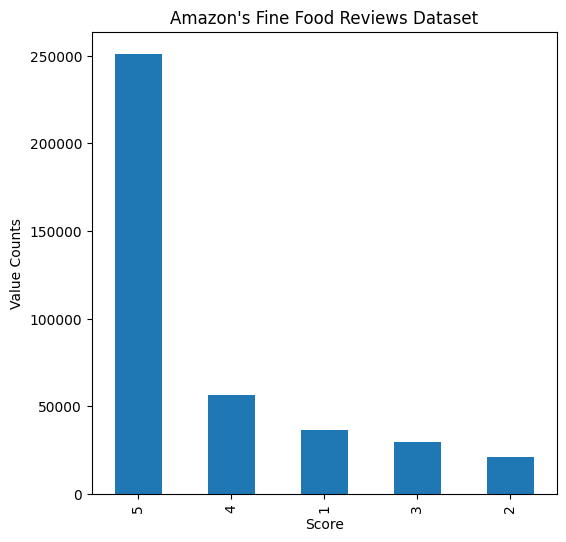

In [17]:
%matplotlib inline
ax = df['Score'].value_counts().plot(kind='bar', figsize=(6,6))
fig = ax.get_figure()
ax.set_title("Amazon's Fine Food Reviews Dataset")
ax.set_xlabel('Score')
ax.set_ylabel('Value Counts');

- Dataset has 5-star rating system and ratings are highly unbalanced. Due to high number of 5-star rating, I have decided to label score 4 and 5 as positive and else negative.

In [18]:
df['Label'] = 0
df.loc[df['Score'] > 3, ['Label']] = 1

len(df[df['Label'] == 1])/len(df)

0.779469630426946

# Text Preprocessing

In [19]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [20]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

In [21]:
df['Text_Cleaned'] = list(map(clean_text, df.Text))

In [22]:
def lemmatized_words(text):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda word:
                                     list(map(lemm.lemmatize, word)),
                                     df.Text_Cleaned))
    

lemmatized_words(df.Text_Cleaned)

In [23]:
pd.set_option('max_colwidth', 500)
df[['Score', 'Text', 'Label', 'Text_Cleaned', 'lemmatized_text']].sample(3)

,Score,Text,Label,Text_Cleaned,lemmatized_text
225814,2,"I was expecting these crisps to be more like a chip. Instead, they have the consistency of a rice cake. They almost melt in your mouth which is kind of strange. Good flavor though, if you can get past the rice cake ness.",0,"[expecting, crisps, like, chip, instead, consistency, rice, cake, almost, melt, mouth, kind, strange, good, flavor, though, get, past, rice, cake, ness]","[expecting, crisp, like, chip, instead, consistency, rice, cake, almost, melt, mouth, kind, strange, good, flavor, though, get, past, rice, cake, ness]"
1330,5,"I figured there must be bacon out there like bacon used to be - this is it. If you are of a 'certain age' (over 40 or 50?) you remember the deep smoky flavor of a good bacon; this cannot be found in ""store bacon"" anymore. Modern bacon is thin, lightly/poorly smoked - even the so-called 'gourmet' bacon. This is the old fashioned flavor and thickness of bacon the way it was in the ""good old days."" Arrives nice and cool in an ice pack - cheaper if you buy the 12-pack.",1,"[figured, must, bacon, like, bacon, used, certain, age, 40, 50, remember, deep, smoky, flavor, good, bacon, cannot, found, store, bacon, anymore, modern, bacon, thin, lightly, poorly, smoked, even, called, gourmet, bacon, old, fashioned, flavor, thickness, bacon, way, good, old, days, arrives, nice, cool, ice, pack, cheaper, buy, 12, pack]","[figured, must, bacon, like, bacon, used, certain, age, 40, 50, remember, deep, smoky, flavor, good, bacon, cannot, found, store, bacon, anymore, modern, bacon, thin, lightly, poorly, smoked, even, called, gourmet, bacon, old, fashioned, flavor, thickness, bacon, way, good, old, day, arrives, nice, cool, ice, pack, cheaper, buy, 12, pack]"
477899,5,This handy little drawer fits perfectly underneath my Keurig while still leaving enough room under the counter to insert k-cups. I love that the cups are so available and organized. Worth every penny in my opinion.,1,"[handy, little, drawer, fits, perfectly, underneath, keurig, still, leaving, enough, room, counter, insert, k, cups, love, cups, available, organized, worth, every, penny, opinion]","[handy, little, drawer, fit, perfectly, underneath, keurig, still, leaving, enough, room, counter, insert, k, cup, love, cup, available, organized, worth, every, penny, opinion]"


In [25]:
bow_converter = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
x = bow_converter.fit_transform(df['Text_Cleaned'])

words = bow_converter.get_feature_names_out()
len(words)

110421

In [28]:
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=(2, 2), lowercase=False) 
x2 = bigram_converter.fit_transform(df['Text_Cleaned'])
bigrams = bigram_converter.get_feature_names_out()
len(bigrams)

4189277

In [31]:
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=(3, 3), lowercase=False) 
x3 = trigram_converter.fit_transform(df['Text_Cleaned'])
trigrams = trigram_converter.get_feature_names_out()
len(trigrams)

11572510

In [32]:
print(len(words), len(bigrams), len(trigrams))

110421 4189277 11572510


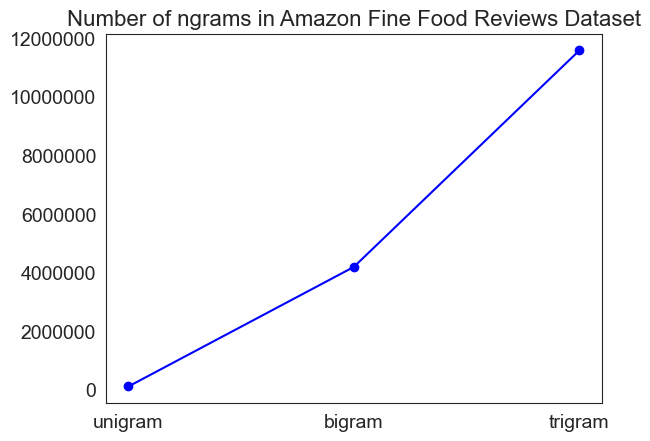

In [33]:
sns.set_style("white")
counts = [len(words), len(bigrams), len(trigrams)]
plt.plot(counts, color='blue')
plt.plot(counts, 'bo')
#plt.margins(0.1)
plt.ticklabel_format(style = 'plain')
plt.xticks(range(3), ['unigram', 'bigram', 'trigram'])
plt.tick_params(labelsize=14)
plt.title('Number of ngrams in Amazon Fine Food Reviews Dataset', {'fontsize':16})
plt.show()

# Bag of Words Transformation

In [34]:
training_data, test_data = sklearn.model_selection.train_test_split(df, train_size = 0.7, random_state=42)

In [35]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=(3,3), lowercase=False) 

In [36]:
X_tr_bow = bow_transform.fit_transform(training_data['Text_Cleaned'])

In [37]:
len(bow_transform.vocabulary_)

8383970

In [38]:
X_te_bow = bow_transform.transform(test_data['Text_Cleaned'])

In [39]:
y_tr = training_data['Label']
y_te = test_data['Label']

# Tf-Idf Tranformation

In [40]:
tfidf_transform = text.TfidfTransformer(norm=None)
X_tr_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_te_tfidf = tfidf_transform.transform(X_te_bow)

# Classification with Logistic Regression

In [41]:
def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

In [42]:
model_bow = simple_logistic_classify(X_tr_bow, y_tr, X_te_bow, y_te, 'bow')
model_tfidf = simple_logistic_classify(X_tr_tfidf, y_tr, X_te_tfidf, y_te, 'tf-idf')

Test Score with bow features 0.8085804950285593
Test Score with tf-idf features 0.8157986037656019


In [43]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5,
                                   param_grid=param_grid_)

In [44]:
bow_search.fit(X_tr_bow, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [45]:
bow_search.best_score_

0.8148611561067293

In [46]:
tfidf_search.fit(X_tr_tfidf, y_tr)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.001, 0.1, 1.0, 10.0, 100.0]})

In [47]:
tfidf_search.best_score_

0.8207761582894723

In [48]:
search_results = pd.DataFrame.from_dict({'bow': bow_search.cv_results_['mean_test_score'],'tfidf': tfidf_search.cv_results_['mean_test_score']})
search_results

,bow,tfidf
0,0.779212,0.779237
1,0.779262,0.790443
2,0.794026,0.802984
3,0.803869,0.810712
4,0.808214,0.820776
5,0.814861,0.820722


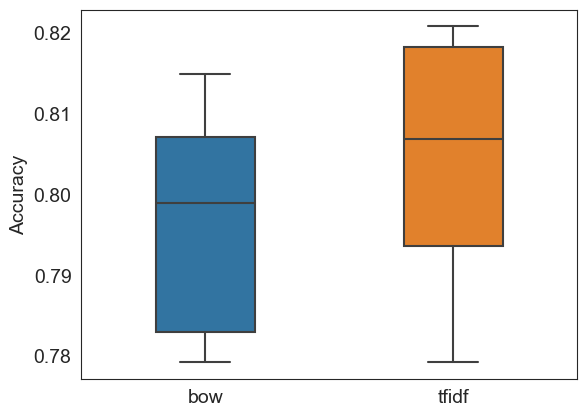

In [49]:
ax = sns.boxplot(data=search_results, width=0.4)
ax.set_ylabel('Accuracy', size=14)
ax.tick_params(labelsize=14)
plt.savefig('tfidf_gridcv_results.png')